In [1]:
#import necessary packages for computation
import numpy as np
import xarray as xr
from scipy import stats,signal
import scipy.fftpack as fftpack
from scipy.interpolate import interp1d,CubicSpline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import cartopy.crs as ccrs
from math import *
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
#import QSW computation functions
from funs_for import *
from funs_for_nonum import *

In [2]:
#Import Function calculating the annomaly correlation coefficient
#Use .apply_ufunc instead of xarray automated (more efficient)
def acc_fun(f,o):
    subf = lambda x,y:x-y
    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    fclim =  f.mean(dim = 'time')
    oclim = o.mean(dim = 'time')
    fanom = xr.apply_ufunc(subf, f, fclim)
    oanom = xr.apply_ufunc(subf, o, oclim)
    
    num = xr.apply_ufunc(multf,fanom,oanom).sum(dim='time')
    
    fanomsq = xr.apply_ufunc(sqf, fanom).sum(dim ='time')
    oanomsq = xr.apply_ufunc(sqf, oanom).sum(dim ='time')
    
    fanomrad = xr.apply_ufunc(radf, fanomsq)
    oanomrad = xr.apply_ufunc(radf, oanomsq)
    
    
    den = xr.apply_ufunc(multf, fanomrad,oanomrad)
    
    acc = xr.apply_ufunc(divf, num,den)
    return acc

In [3]:
#Function calculating the mean squared skill score
def mss_fun(f,o):
    squared_error = lambda x, y: (x - y) ** 2
    divf = lambda x,y:x/y
    
    oclim = o.mean(dim = 'time')

    num = xr.apply_ufunc(squared_error, f, o).sum(dim='time')
    den = xr.apply_ufunc(squared_error, o, oclim).sum(dim='time')
    mss = 1-xr.apply_ufunc(divf,num,den)
    return mss

In [4]:
#Function calculating the skill across ensembles
def ap_ensemble (f,o):
    acc_out=f.mean(dim='time').copy(deep=True)
    mss_out=f.mean(dim='time').copy(deep=True)
    for i in range(len(f.number.values)):
        f_cur=f.isel(number=i)
        acc_cur = acc_fun(f_cur,o)
        mss_cur=mss_fun(f_cur,o)
        acc_out[:,i]=acc_cur
        mss_out[:,i]=mss_cur
    return acc_out,mss_out

In [5]:
%matplotlib inline

In [5]:
#functions to calculate anomalies
def ob_anom(obd):
    a = pd.to_datetime('2020-11-10')
    dates = []
    days=[]
    months=[]

    alldat=[]
    for j in range (27):
        da = a.day
        mo = a.month
        dat=obd.q.sel(time = (obd.time.dt.month==mo)&(obd.time.dt.day==da))
        alldat.append(dat)

        dates.append(a)
        if j%2==0:
            a=a+timedelta(4)
        else:
            a=a+timedelta(3)

    middat = alldat[2:-2]
    datesmid = dates[2:-2]
    val = [1,2,3,4,5]

    climdats=[]
    anomdats=[]

    for i in range(len(middat)):
        dest = middat[i].copy()
        dest = dest.expand_dims({'set':5})
        dest = dest.assign_coords(set = ('set',val))
        dest2 = dest.copy()
        #print(dest2[0,])
        inp1 = alldat[i].copy()
        #print(inp1)
        inp2 = alldat[i+1].copy()
        inp3 = alldat[i+2].copy()
        inp4 = alldat[i+3].copy()
        inp5 = alldat[i+4].copy()

        dest2[0,] = inp1.values
        dest2[1,] = inp2.values
        dest2[2,] = inp3.values
        dest2[3,] = inp3.values
        dest2[4,] = inp4.values

        dest_fin = dest2.mean(dim = "time")
        dest_fin = dest_fin.mean(dim = 'set')
        #   dest_fin = dest_fin.mean(dim = 'number')
        anom=middat[i]-dest_fin
        climdats.append(dest_fin)
        anomdats.append(anom)

    anomally=xr.concat(anomdats,dim='time')
    anomally=anomally.sortby(anomally.time)
    climatology=xr.concat(climdats,dim='time')
    climatology=climatology.sortby(climatology.time)
    
    return anomally,climatology

def ob_anom_7d(obd):
    #for hmcr
    a = pd.to_datetime('2020-11-10')
    dates = []
    days=[]
    months=[]

    alldat=[]
    for j in range (14):
        da = a.day
        mo = a.month
        dat=obd.q.sel(time = (obd.time.dt.month==mo)&(obd.time.dt.day==da))
        alldat.append(dat)

        dates.append(a)
        
        a=a+timedelta(7)

    middat = alldat[2:-2]
    datesmid = dates[2:-2]
    val = [1,2,3,4,5]

    climdats=[]
    anomdats=[]

    for i in range(len(middat)):
        dest = middat[i].copy()
        dest = dest.expand_dims({'set':5})
        dest = dest.assign_coords(set = ('set',val))
        dest2 = dest.copy()
        #print(dest2[0,])
        inp1 = alldat[i].copy()
        #print(inp1)
        inp2 = alldat[i+1].copy()
        inp3 = alldat[i+2].copy()
        inp4 = alldat[i+3].copy()
        inp5 = alldat[i+4].copy()

        dest2[0,] = inp1.values
        dest2[1,] = inp2.values
        dest2[2,] = inp3.values
        dest2[3,] = inp3.values
        dest2[4,] = inp4.values

        dest_fin = dest2.mean(dim = "time")
        dest_fin = dest_fin.mean(dim = 'set')
        #   dest_fin = dest_fin.mean(dim = 'number')
        anom=middat[i]-dest_fin
        climdats.append(dest_fin)
        anomdats.append(anom)

    anomally=xr.concat(anomdats,dim='time')
    anomally=anomally.sortby(anomally.time)
    climatology=xr.concat(climdats,dim='time')
    climatology=climatology.sortby(climatology.time)
    
    return anomally,climatology


def anom_monthly(dat):
    #for meteof
    climatology=dat.q.groupby('time.month').mean()
    anomally=dat.q.groupby('time.month')-climatology
    
    return anomally,climatology

def fo_anom(fod):
    a = pd.to_datetime('2020-11-10')
    dates = []
    days=[]
    months=[]

    alldat=[]
    for j in range (27):
        da = a.day
        mo = a.month
        dat=fod.q.sel(time = (fod.time.dt.month==mo)&(fod.time.dt.day==da))
        alldat.append(dat)

        dates.append(a)
        if j%2==0:
            a=a+timedelta(4)
        else:
            a=a+timedelta(3)

    middat = alldat[2:-2]
    datesmid = dates[2:-2]
    val = [1,2,3,4,5]

    climdats=[]
    anomdats=[]

    for i in range(len(middat)):
        dest = middat[i].copy()
        dest = dest.expand_dims({'set':5})
        dest = dest.assign_coords(set = ('set',val))
        dest2 = dest.copy()
        #print(dest2[0,])
        inp1 = alldat[i].copy()
        #print(inp1)
        inp2 = alldat[i+1].copy()
        inp3 = alldat[i+2].copy()
        inp4 = alldat[i+3].copy()
        inp5 = alldat[i+4].copy()

        dest2[0,] = inp1.values
        dest2[1,] = inp2.values
        dest2[2,] = inp3.values
        dest2[3,] = inp3.values
        dest2[4,] = inp4.values

        dest_fin = dest2.mean(dim = "time")
        dest_fin = dest_fin.mean(dim = 'set')
        dest_fin = dest_fin.mean(dim = 'number')
        anom=middat[i]-dest_fin
        climdats.append(dest_fin)
        anomdats.append(anom)

    anomally=xr.concat(anomdats,dim='time')
    anomally=anomally.sortby(anomally.time)
    climatology=xr.concat(climdats,dim='time')
    climatology=climatology.sortby(climatology.time)
    
    return anomally,climatology

def fo_anom_7d(fod):
    a = pd.to_datetime('2020-11-10')
    dates = []
    days=[]
    months=[]

    alldat=[]
    for j in range (14):
        da = a.day
        mo = a.month
        dat=fod.q.sel(time = (fod.time.dt.month==mo)&(fod.time.dt.day==da))
        alldat.append(dat)

        dates.append(a)

        a=a+timedelta(7)

    middat = alldat[2:-2]
    datesmid = dates[2:-2]
    val = [1,2,3,4,5]

    climdats=[]
    anomdats=[]

    for i in range(len(middat)):
        dest = middat[i].copy()
        dest = dest.expand_dims({'set':5})
        dest = dest.assign_coords(set = ('set',val))
        dest2 = dest.copy()
        #print(dest2[0,])
        inp1 = alldat[i].copy()
        #print(inp1)
        inp2 = alldat[i+1].copy()
        inp3 = alldat[i+2].copy()
        inp4 = alldat[i+3].copy()
        inp5 = alldat[i+4].copy()

        dest2[0,] = inp1.values
        dest2[1,] = inp2.values
        dest2[2,] = inp3.values
        dest2[3,] = inp3.values
        dest2[4,] = inp4.values

        dest_fin = dest2.mean(dim = "time")
        dest_fin = dest_fin.mean(dim = 'set')
        dest_fin = dest_fin.mean(dim = 'number')
        anom=middat[i]-dest_fin
        climdats.append(dest_fin)
        anomdats.append(anom)

    anomally=xr.concat(anomdats,dim='time')
    anomally=anomally.sortby(anomally.time)
    climatology=xr.concat(climdats,dim='time')
    climatology=climatology.sortby(climatology.time)
    
    return anomally,climatology

In [7]:
#anomally based evaluation metrics
def acc_new(fanom,oanom):

    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    
    num = xr.apply_ufunc(multf,fanom,oanom).sum(dim='time')
    
    fanomsq = xr.apply_ufunc(sqf, fanom).sum(dim ='time')
    oanomsq = xr.apply_ufunc(sqf, oanom).sum(dim ='time')
    
    fanomrad = xr.apply_ufunc(radf, fanomsq)
    oanomrad = xr.apply_ufunc(radf, oanomsq)
    
    
    den = xr.apply_ufunc(multf, fanomrad,oanomrad)
    
    acc = xr.apply_ufunc(divf, num,den)
    
    return acc

#Function calculating the mean squared skill score
def mss_new(f,o, oclim):
    squared_error = lambda x, y: (x - y) ** 2
    divf = lambda x,y:x/y
    
    oclim = oclim.mean(dim = 'time')

    num = xr.apply_ufunc(squared_error, f, o).sum(dim='time')
    den = xr.apply_ufunc(squared_error, o, oclim).sum(dim='time')
    mss = 1-xr.apply_ufunc(divf,num,den)
    return mss

In [8]:
#homoegeneous acc
def acc_hom(fanom):

    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    accs=[]
    for i in range(len(fanom.number)):
        ver=fanom.isel(number=i)
        rem=fanom.sel(number=fanom.number!=fanom.number[i]).mean(dim='number')
        
        num = xr.apply_ufunc(multf,rem,ver).sum(dim='time')

        fanomsq = xr.apply_ufunc(sqf, rem).sum(dim ='time')
        oanomsq = xr.apply_ufunc(sqf, ver).sum(dim ='time')

        fanomrad = xr.apply_ufunc(radf, fanomsq)
        oanomrad = xr.apply_ufunc(radf, oanomsq)


        den = xr.apply_ufunc(multf, fanomrad,oanomrad)

        acc = xr.apply_ufunc(divf, num,den)
        accs.append(acc)
        
    acc_tot_number=xr.concat(accs,dim='number')
    acc_tot=acc_tot_number.mean(dim='number')
    
    return acc_tot


In [7]:
#BSS function
def BSS(f,o):
    o=observed_data[models[i]].q
    f=forecast_data[models[i]].q

    ot95=xr.where(o>o.quantile(0.95,dim='time'),1,0)
    bsf=(ot95.mean(dim='time'))*(1.-ot95.mean(dim='time'))

    ft95=xr.where(f>f.quantile(0.95,dim='time'),1,0)
    pk=ft95.mean(dim='number')

    bs=((pk-ot95)**2).mean(dim='time')
    bss=1-(bs/bsf)

    return bss
        
        

## Apply QSW to forecast data - save to files

In [6]:
#Compute QSWs in forecast data and save to files
a = pd.to_datetime('2020-11-03')
dates = []
anoms = []
fors = [] #forecast datasets later to be used to create era data str.
v_rear_fo = []  #Original v data to look at climatology
v_rear_15_fo = [] #15day smoothed v data  to compare with raw v
waves_fo=[] #computed wave data on each start date 

#Define number of steps to be cut from start dates on each end
st_cut=21
end_cut=-3

for i in range (30):
    #For each start date, separate the date and time to read in the data
    da = a.strftime('%d')
    mo = a.strftime('%m')
    dat1 = xr.open_dataset('forecast_nc/v300_'+str(mo)+'_'+str(da)+'.nc')
    
    #The next start date is either 4 or 3 days after the current one
    if i%2==0:
        a=a+timedelta(4)
    else:
        a=a+timedelta(3)
    
    #For early start dates remove the first few steps lying before december 1
    
   
    #Append the raw v data to a list and calculate climatology for the start date
    fors.append(dat1)     
    dat1 = dat1.sel(latitude=slice(85,20))
    clim_raw = dat1.mean(dim='time')
    v_rear_fo.append(clim_raw)
    

#     dat1 = dat1.rolling(step=15, center=True).mean()     #Smooth data with 15 day rolling mean
#     Using low pass filter instead
    dat1 = xr.apply_ufunc(apply_low_pass_filter,dat1,input_core_dims=[['step']],output_core_dims=[['step']])
    
    
    #For the climatology, rolled data already calculated in cleaning stade
    dat2 = xr.open_dataset('forecast_nc/v300_'+str(mo)+'_'+str(da)+'_clim.nc')
    dat2 = dat2.sel(latitude=slice(85,20))
    v_rear_15_fo.append(dat2)
    
    #Calculate v anomalies of smoothed date
    anom = dat1 - dat2
    anoms.append(dat1-dat2)
    
    #transpose data to bring longituge to last axis for wave decomposition
    anoms_0=anom.transpose("time","step","number","latitude","longitude")[["time","step","latitude","longitude","number","v"]].v
    
    #remove first and last 7 steps (nan after smoothing)
#    anoms_0=anoms_0.isel(step=slice(7,-7))
    if (int(mo)>3):
        #tmin = npmin(anom.time.dt.day)
        mint=anoms_0.sel(time=anom.time.dt.day==np.min(anom.time.dt.day))

        ye=mint.time[0].dt.year.values
        st_date = pd.to_datetime(str(ye)+'-12-01')

        dd=(st_date -mint.isel(step=0).valid_time.values[0])
        st_cut = max(0,dd / np.timedelta64(1, 'D'))
        #print(i,st_cut)
        #instead of all start at dec 1 (not possible because the step dimension not consistent)
        #Here, we are using the earliest date to find the step to dec 1 and cutting every other date from that step
        #this makes the other dates' valid time vary around dec 1,2 ,3 etc but have the same step size and values
        anoms_0=anoms_0.isel(step=slice(int(st_cut),-1))


    else:
        mint=anoms_0.sel(time=anom.time.dt.day==np.max(anom.time.dt.day))
        ye=mint.time[0].dt.year.values
        st_date2 = pd.to_datetime(str(ye)+'-02-22')
        end_date = pd.to_datetime(str(ye)+'-02-28')

        dd1 = (mint.isel(step=-1).valid_time.values[0]- end_date)
        end_cut = max(0,dd1 / np.timedelta64(1, 'D'))
        dd2=(st_date2 -mint.isel(step=0).valid_time.values[0])
        if dd2 / np.timedelta64(1, 'D')<0:
            continue
        anoms_0=anoms_0.isel(step=slice(0,len(mint.step)-int(end_cut)))
    
    #calculate QSW over wavekengths 3500 to 7000
    wave = calc_wavepacket_3D_for(anoms_0,3500,7000)
    wvmn=wave.mean(dim='time')
    waves_fo.append(wvmn)
    dates.append(a)
    #Save data to file
    wave = wave.to_dataset(name='q')
    wave.to_netcdf('forecast_q/q_'+str(mo)+'_'+str(da)+'.nc')
    

In [ ]:
#Concatenate initialization dates as one and save to files
foreacsted = xr.concat(waves_fo,dim = 'time')
forecasted.to_netcdf('output/nosmooth_ecmwf_nov_jan.nc')

## Apply QSW to ERA5 data - save to files

In [11]:
#Read in era5 v data
vdat = xr.open_dataset('/scratch/rwhite/ladmasu/s2s/v300/era5_v300_1.5_regrid.nc')

#Remove data before 2001 (no reforecast)
v =vdat.v
#v=v.sel(time=v.time.dt.year.isin(np.arange(1996,2017)))
v=v.sel(time=v.time.dt.year>2001)
v=v.rename({'lon':'longitude','lat':'latitude'})

In [13]:
#Subset era data into start dates with years as time and subsequent dates as step to match forecast data
#Perform before SMOOTHING to make similar nans in the step axis on each start dates (avoid issues with poisson smoothing)

#Define start date and empty lists
a = pd.to_datetime('2020-11-03')
dates = []
v_rear_era = [] #Original v data to look at climatology
v_rear_15_era = [] #15day smoothed v data  to compare with raw v
waves_era=[] #computed wave data on each start date 

for i in range (30):
    #For each forecast start dates, identify corresponding era5 data
    da = a.day
    mo = a.month
    firsts = v.sel(time = (v.time.dt.day == da) & (v.time.dt.month==mo))
    
    #Since era5 continuoous, make sure data starts with november 2002 into feb 2003
    #and ends with november 2021 into feb 2022
    if (mo>3):
        firsts = firsts.sel(time=firsts.time.dt.year<2016)
        
    else:
        firsts = firsts.sel(time=firsts.time.dt.year>1996)
    
    #Expand data to define a step axis with similar dimensions as forecast data
    dats =  xr.zeros_like(firsts)
    dats = dats.expand_dims(step = fors[i].step).copy()
    
 #identify the dates corresponding to the forecasted timesteps
    for j in range(len(firsts.time)):
        #For each year of the start data data, identify subsequent dates as "forecasted" steps 
        init = firsts.time[j].values 
        fin = init+np.timedelta64(len(fors[i].step)-1,'D')
        if mo <3:
            ye=pd.DatetimeIndex([firsts.time[j].values]).year[0]
            cutdate = pd.to_datetime(str(ye)+'-02-28')
            fin = min(fin,cutdate)
    
        newlen=(fin-init)//np.timedelta64(1,'D')
        if newlen < len(fors[i].step)-1:
            dats = dats.isel(step = slice(0,newlen+1))


        stepd = pd.date_range(init,fin, freq='D')
        dat = v.sel(time = stepd) #extract era5 data on the forecasted dates
        dats[:,j,:,:]=dat.values #assign the data as steps into the dataset
    
    #Calculate climatology of the start date original v data
    dats =dats.sel(latitude=slice(85,20))
    
    #Smooth v data with 15 day rolling mean and calculate climatology
    #dats=dats.rolling(step=15, center=True).mean()  
    dats = xr.apply_ufunc(apply_low_pass_filter,dats,input_core_dims=[['step']],output_core_dims=[['step']])
    clim = dats.mean(dim='time')
    v_rear_15_era.append(clim)
    
    #calculate anomalies and transpose longitude axis for wave decomposition
    anom = dats - clim
    anoms.append(anom.mean(dim='time'))
    anom = anom.to_dataset(name = 'v')
    anom_0=anom.transpose("time","step","latitude","longitude")[["step","time","latitude","longitude","v"]].v

    
    if (int(mo)>3):
        #tmin = npmin(anom.time.dt.day)
        mint=anom_0.isel(time=0)

        ye=mint.time.dt.year.values
        st_date = pd.to_datetime(str(ye)+'-12-01')

        dd=(st_date -mint.time.values)
        st_cut = max(0,dd / np.timedelta64(1, 'D'))
        #print(i,st_cut)
        #instead of all start at dec 1 (not possible because the step dimension not consistent)
        #Here, we are using the earliest date to find the step to dec 1 and cutting every other date from that step
        #this makes the other dates' valid time vary around dec 1,2 ,3 etc but have the same step size and values
        anom_0=anom_0.isel(step=slice(int(st_cut),-1))


    else:
        mint=anom_0.isel(time=0)
        ye=mint.time.dt.year.values
        st_date2 = pd.to_datetime(str(ye)+'-02-22')
        end_date = pd.to_datetime(str(ye)+'-02-28')

        dd1 = (mint.time.values+np.timedelta64(len(mint.step.values), 'D')- end_date)
        end_cut = max(0,dd1 / np.timedelta64(1, 'D'))
        dd2=(st_date2 -mint.time.values)
        if dd2 / np.timedelta64(1, 'D')<0:
            continue
        anom_0=anom_0.isel(step=slice(0,len(mint.step)-int(end_cut)))
    #Remove first and last 7 days and calculate waves using function
    #anom_0=anom_0.isel(step=slice(7,-7))
    wave = calc_wavepacket_3D_for2(anom_0,3500,7000)
    
    #Save wave data to file, and calculate climatology
    wvmn=wave.mean(dim='time')
    waves_era.append(wvmn)
    wave= wave.to_dataset(name='q')
    wave.to_netcdf('Era_q_v2016full/eraq_'+str(mo)+'_'+str(da)+'.nc')
    
    #The next start date is either 3 or 4 days ahead
    if i%2==0:
        a=a+timedelta(4)
    else:
        a=a+timedelta(3)

In [12]:
#Calculate QSWs and save to files
a = pd.to_datetime('2020-11-03')
dates = []
v_rear_era = [] #Original v data to look at climatology
v_rear_15_era = [] #15day smoothed v data  to compare with raw v
waves_era=[] #computed wave data on each start date 

for i in range (30):
    #For each forecast start dates, identify corresponding era5 data
    da = a.day
    mo = a.month
    firsts = v.sel(time = (v.time.dt.day == da) & (v.time.dt.month==mo))
    
    #Since era5 continuoous, make sure data starts with november 2002 into feb 2003
    #and ends with november 2021 into feb 2022
    if (mo>3):
        firsts = firsts.sel(time=firsts.time.dt.year<2022)
        
    else:
        firsts = firsts.sel(time=firsts.time.dt.year>2002)
    
    #Expand data to define a step axis with similar dimensions as forecast data
    dats =  xr.zeros_like(firsts)
    dats = dats.expand_dims(step = fors[i].step).copy()
    
 #identify the dates corresponding to the forecasted timesteps
    for j in range(len(firsts.time)):
        #For each year of the start data data, identify subsequent dates as "forecasted" steps 
        init = firsts.time[j].values 
        fin = init+np.timedelta64(len(fors[i].step)-1,'D')
        if mo <3:
            ye=pd.DatetimeIndex([firsts.time[j].values]).year[0]
            cutdate = pd.to_datetime(str(ye)+'-02-28')
            fin = min(fin,cutdate)
    
        newlen=(fin-init)//np.timedelta64(1,'D')
        if newlen < len(fors[i].step)-1:
            dats = dats.isel(step = slice(0,newlen+1))


        stepd = pd.date_range(init,fin, freq='D')
        dat = v.sel(time = stepd) #extract era5 data on the forecasted dates
        dats[:,j,:,:]=dat.values #assign the data as steps into the dataset
    
    #Calculate climatology of the start date original v data
    dats =dats.sel(latitude=slice(85,20))
    
    #Smooth v data with 15 day rolling mean and calculate climatology
    #dats=dats.rolling(step=15, center=True).mean()  
    dats = xr.apply_ufunc(apply_low_pass_filter,dats,input_core_dims=[['step']],output_core_dims=[['step']])
    clim = dats.mean(dim='time')
    v_rear_15_era.append(clim)
    
    #calculate anomalies and transpose longitude axis for wave decomposition
    anom = dats - clim
    anoms.append(anom.mean(dim='time'))
    anom = anom.to_dataset(name = 'v')
    anom_0=anom.transpose("time","step","latitude","longitude")[["step","time","latitude","longitude","v"]].v

    
    if (int(mo)>3):
        #tmin = npmin(anom.time.dt.day)
        mint=anom_0.isel(time=0)

        ye=mint.time.dt.year.values
        st_date = pd.to_datetime(str(ye)+'-12-01')

        dd=(st_date -mint.time.values)
        st_cut = max(0,dd / np.timedelta64(1, 'D'))
        #print(i,st_cut)
        #instead of all start at dec 1 (not possible because the step dimension not consistent)
        #Here, we are using the earliest date to find the step to dec 1 and cutting every other date from that step
        #this makes the other dates' valid time vary around dec 1,2 ,3 etc but have the same step size and values
        anom_0=anom_0.isel(step=slice(int(st_cut),-1))


    else:
        mint=anom_0.isel(time=0)
        ye=mint.time.dt.year.values
        st_date2 = pd.to_datetime(str(ye)+'-02-22')
        end_date = pd.to_datetime(str(ye)+'-02-28')

        dd1 = (mint.time.values+np.timedelta64(len(mint.step.values), 'D')- end_date)
        end_cut = max(0,dd1 / np.timedelta64(1, 'D'))
        dd2=(st_date2 -mint.time.values)
        if dd2 / np.timedelta64(1, 'D')<0:
            continue
        anom_0=anom_0.isel(step=slice(0,len(mint.step)-int(end_cut)))
    #Remove first and last 7 days and calculate waves using function
    #anom_0=anom_0.isel(step=slice(7,-7))
    wave = calc_wavepacket_3D_for2(anom_0,3500,7000)
    
    #Save wave data to file, and calculate climatology
    wvmn=wave.mean(dim='time')
    waves_era.append(wvmn)
    wave= wave.to_dataset(name='q')
    wave.to_netcdf('Era_q/eraq_'+str(mo)+'_'+str(da)+'.nc')
    
    #The next start date is either 3 or 4 days ahead
    if i%2==0:
        a=a+timedelta(4)
    else:
        a=a+timedelta(3)

In [ ]:
#Concatenate and save to one file
observed = xr.concat(waves_era,dim = 'time')
observed.to_netcdf('output/nosmooth_era_nov_jan.nc')


## Read QSWs back in

In [8]:
#Read unsmoothed data in if already computed
forecast_data = {}
observed_data = {}
models = ['ecmwf','cma','hmcr','meteof']
for i in range(4):
    observed_data[models[i]]=xr.open_dataset(models[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models[i]]=xr.open_dataset(models[i]+'/output/nosmooth_'+models[i]+'_nov_jan.nc')

In [9]:
#ECMWF version 2
ecmwf_ext_fo = xr.open_dataset(models[0]+'/output/nosmooth_ecmwf_v2016full.nc')
ecmwf_ext_ob = xr.open_dataset(models[0]+'/output/nosmooth_era_v2016full.nc')
forecast_data['execm']=ecmwf_ext_fo
observed_data['execm']=ecmwf_ext_ob

## Compute climatologies and evaluation metrics

## Plot results (climatology)

In [14]:
#calculate bias and variability
climbias=(forecast_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['time','step','number'])-observed_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['time','step']))
climmod=forecast_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['step'])
climstack=climmod.stack(z={'time','number'})
climvar=climstack.std(dim='z')

obsvar=observed_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['step']).std(dim=['time'])

varbias=climvar-obsvar

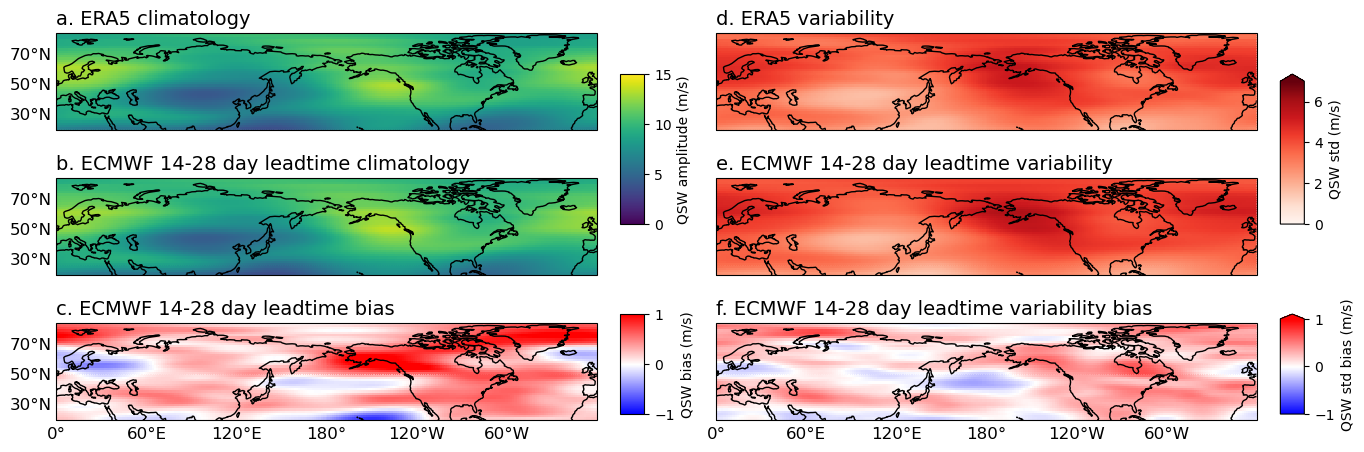

In [41]:
#Plot QSW climatology using 14-28day lead
models1 = ['ECMWF','CMA','HMCR','CNRM']
cm=180
fig = plt.figure(figsize=(24,5))
proj = ccrs.PlateCarree(central_longitude=cm)
ax = fig.add_subplot(3,3,1,projection=proj)
ax.coastlines()
observed_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['time','step']).plot(ax=ax,vmin = 0, vmax = 15,transform = ccrs.PlateCarree(),add_colorbar=False)#,cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW (m/s)'})

ax.set_title('')
ax.set_title('a. ERA5 climatology', fontsize = 14, loc='left')

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax = fig.add_subplot(3,3,4,projection=proj)
ax.coastlines()
m=forecast_data[models[0]].q.isel(step=slice(8,22)).mean(dim=['time','step','number']).plot(ax=ax,vmin = 0, vmax = 15, transform = ccrs.PlateCarree(),add_colorbar=False)#,cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW (m/s)'})

ax.set_title('')
ax.set_title('b. ECMWF 14-28 day leadtime climatology', fontsize = 14, loc='left')

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
# gl.ylabels_left = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

cbar_ax = fig.add_axes([0.36, 0.45, 0.01, 0.3])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="QSW amplitude (m/s)",size=10)
cbl.ax.tick_params(labelsize=10)


titles = [ 'b.', 'c.', 'd.', 'e.']

ax = fig.add_subplot(3,3,7,projection=proj)
m=climbias.plot(ax=ax,cmap = 'bwr', vmax = 1, transform = ccrs.PlateCarree(),add_colorbar=False)#,cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW bias (m/s)'})

ax.set_title('')
ax.set_title('c. '+models1[0]+' 14-28 day leadtime bias',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False

gl.ylabels_right = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

cbar_ax = fig.add_axes([0.36, 0.07, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="QSW bias (m/s)",size=10)
cbl.ax.tick_params(labelsize=10)


ax = fig.add_subplot(3,3,2,projection=proj)
m=obsvar.plot(ax=ax,cmap = 'Reds',vmin=0,vmax=7,  transform = ccrs.PlateCarree(),extend='max',add_colorbar=False)#,cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW std (m/s)'})

ax.set_title('')
ax.set_title('d. ERA5 variability',fontsize = 14, loc='left')

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax = fig.add_subplot(3,3,5,projection=proj)
climvar.plot(ax=ax,cmap = 'Reds',vmin=0,vmax=7,  transform = ccrs.PlateCarree(),add_colorbar=False)#cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW std (m/s)','fontsize':12})

ax.set_title('')
ax.set_title('e. '+models1[0]+' 14-28 day leadtime variability',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

cbar_ax = fig.add_axes([0.635, 0.45, 0.01, 0.3])
cbl=fig.colorbar(m, cax=cbar_ax,extend='max',orientation='vertical')

cbl.set_label(label="QSW std (m/s)",size=10)
cbl.ax.tick_params(labelsize=10)

ax = fig.add_subplot(3,3,8,projection=proj)
m=varbias.plot(ax=ax,cmap = 'bwr',vmin=-1,vmax=1,  transform = ccrs.PlateCarree(),add_colorbar=False)#cbar_kwargs={'orientation':"horizontal",'label': "",'pad':0.15,'label':'QSW std (m/s)','fontsize':12})

ax.set_title('')
ax.set_title('f. '+models1[0]+' 14-28 day leadtime variability bias',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}


cbar_ax = fig.add_axes([0.635, 0.07, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,extend='max',orientation='vertical')

cbl.set_label(label="QSW std bias (m/s)",size=10)
cbl.ax.tick_params(labelsize=10)


plt.subplots_adjust(hspace=0.001, wspace=0.22, bottom=0.01)
#plt.tight_layout()

# plt.show()
plt.savefig('plots/Climatology_climvar_ecmwf_ERA_reviewed_new.png')

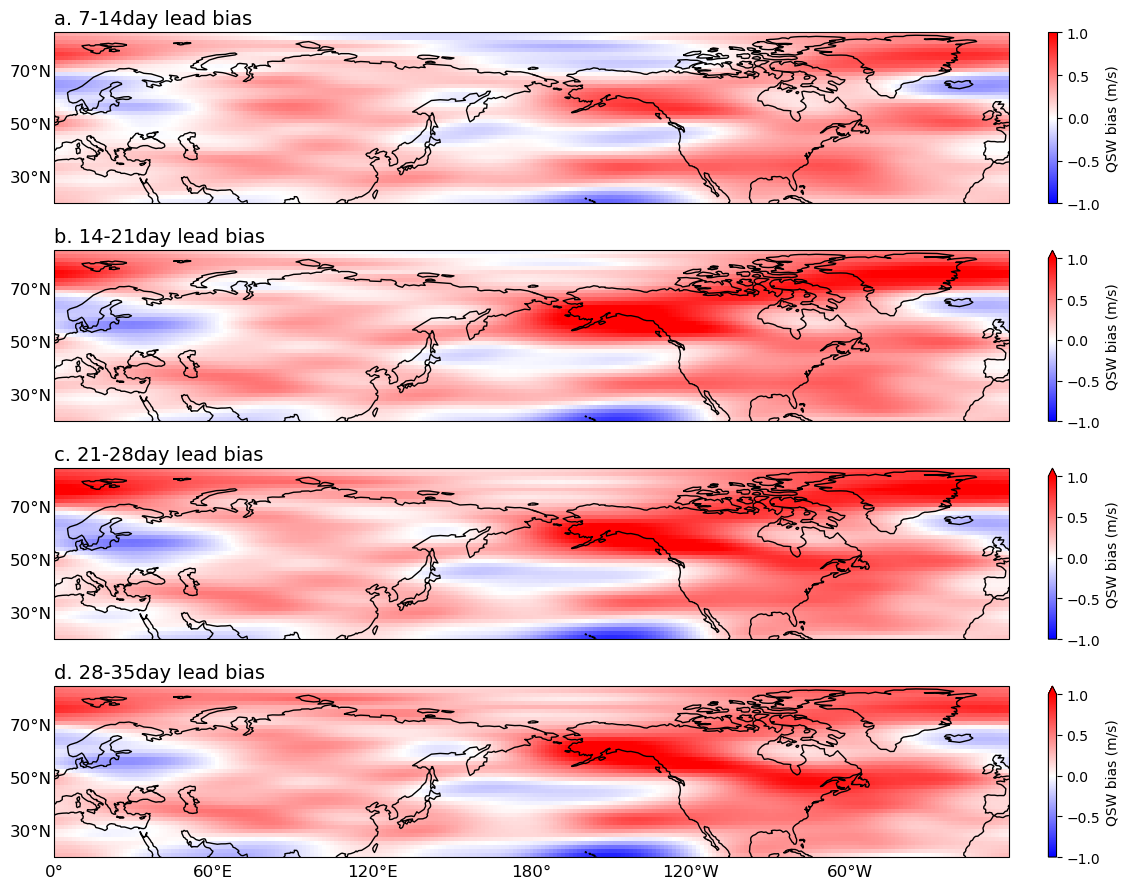

In [27]:
# plot bias at lead times
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(20,9))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [ 'a. ', 'b. ', 'c. ', 'd. ']
   #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

ax = fig.add_subplot(4,1,1,projection=proj)
climbias1=(forecast_data[models[0]].q.isel(step=slice(0,8)).mean(dim=['time','step','number'])-observed_data[models[0]].q.isel(step=slice(0,8)).mean(dim=['time','step']))
climbias1.plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1, transform = ccrs.PlateCarree(), cbar_kwargs={'pad':0.02,'label': "QSW bias (m/s)"})
ax.set_title('')
ax.set_title('a. 7-14day lead bias ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.ylocator = mticker.FixedLocator([30, 50, 70])

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}


ax = fig.add_subplot(4,1,2,projection=proj)
climbias2=(forecast_data[models[0]].q.isel(step=slice(8,15)).mean(dim=['time','step','number'])-observed_data[models[0]].q.isel(step=slice(8,15)).mean(dim=['time','step']))
climbias2.plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1, transform = ccrs.PlateCarree(), cbar_kwargs={'pad':0.02,'label': "QSW bias (m/s)"})
ax.set_title('')
ax.set_title('b. 14-21day lead bias ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlabels_bottom = False
gl.ylocator = mticker.FixedLocator([30, 50, 70])

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}


ax = fig.add_subplot(4,1,3,projection=proj)
climbias3=(forecast_data[models[0]].q.isel(step=slice(15,22)).mean(dim=['time','step','number'])-observed_data[models[0]].q.isel(step=slice(15,22)).mean(dim=['time','step']))
climbias3.plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1, transform = ccrs.PlateCarree(), cbar_kwargs={'pad':0.02,'label': "QSW bias (m/s)"})
ax.set_title('')
ax.set_title('c. 21-28day lead bias ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.ylocator = mticker.FixedLocator([30, 50, 70])

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax = fig.add_subplot(4,1,4,projection=proj)
climbias4=(forecast_data[models[0]].q.isel(step=slice(22,29)).mean(dim=['time','step','number'])-observed_data[models[0]].q.isel(step=slice(22,29)).mean(dim=['time','step']))
m=climbias4.plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1, transform = ccrs.PlateCarree(), cbar_kwargs={'pad':0.02,'label': "QSW bias (m/s)"})
ax.set_title('')
ax.set_title('d. 28-35day lead bias ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
# gl.ylabels_left = False
gl.ylocator = mticker.FixedLocator([30, 50, 70])

gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.015])
# cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
# cbl.set_label(label="QSW bias (m/s)",size=13)
# cbl.ax.tick_params(labelsize=12)

plt.tight_layout()
    #plt.show()
plt.savefig('plots/ecmwf_bias_across_lead.png')

## Calculate anomalies for evaluation

In [28]:
#Read unsmoothed data in if already computed
forecast_data = {}
observed_data = {}
models11 = ['ecmwf','cma','hmcr','meteof']
#models11 = ['ecmwf','execm']
for i in range(len(models11)):
    observed_data[models11[i]]=xr.open_dataset('v300/models/'+models11[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models11[i]]=xr.open_dataset('v300/models/'+models11[i]+'/output/nosmooth_'+models11[i]+'_nov_jan.nc')


In [52]:
#Calculate anomalies
anom_models={}
anom_obs={}
models11 = ['ecmwf','cma','hmcr','meteof'] #meteof has initialization date issues
for i in range((len(models11))):
    obd=observed_data[models11[i]]
    fod=forecast_data[models11[i]]  
    print(i)
    if i==2:
        anom_ob,clim_ob=ob_anom_7d(obd)
        anom_fo,clim_fo=fo_anom_7d(fod)
        anom_obs[models11[i]]=anom_ob
        anom_models[models11[i]]=anom_fo
        
            
    elif i==3:
        anom_ob,clim_ob=anom_monthly(obd)
        anom_fo,clim_fo=anom_monthly(fod)
        anom_obs[models11[i]]=anom_ob
        anom_models[models11[i]]=anom_fo
    else:
        anom_ob,clim_ob=ob_anom(obd)
        anom_fo,clim_fo=fo_anom(fod)
        anom_obs[models11[i]]=anom_ob
        anom_models[models11[i]]=anom_fo
               
    anom_models[models11[i]].to_dataset(name='q').to_netcdf(models11[i]+'_forecaset_qsw_anomally.nc')
    anom_obs[models11[i]].to_dataset(name='q').to_netcdf(models11[i]+'_observed_qsw_anomally.nc')

0
1
2
3


In [58]:
#save to files
anom_ob.to_dataset(name='q').to_netcdf('observed_qsw_anomally.nc')
clim_ob.to_dataset(name='q').to_netcdf('observed_qsw_climatology.nc')

anom_fo.to_dataset(name='q').to_netcdf('forecaset_ecmwf_qsw_anomally.nc')
clim_fo.to_dataset(name='q').to_netcdf('forecast_ecmwf_qsw_climatology.nc')

## Re open anomalies and evaluate ecmwf

In [28]:
#reopen files
models11 = ['ecmwf','cma','hmcr','meteof']
anom_models={}
anom_obs={}
for i in range((len(models11))):
    anom_fo=xr.open_dataset(models11[i]+'_forecaset_qsw_anomally.nc')
    anom_ob=xr.open_dataset(models11[i]+'_observed_qsw_anomally.nc')

    anom_models[models11[i]]=anom_fo.q
    anom_obs[models11[i]]=anom_ob.q

In [60]:
#Evaluate models (acc,and homogeneous acc)
acc_models={}
acc_homs={}
for i in range((len(models11))):
    acc=acc_new(anom_models[models11[i]].mean(dim='number'),anom_obs[models11[i]])
    acc_homog=acc_hom(anom_models[models11[i]])
    acc_models[models11[i]]=acc
    acc_homs[models11[i]]=acc_homog
    acc.to_dataset(name='acc').to_netcdf(models11[i]+'_acc_anomally-based.nc')
    acc_homog.to_dataset(name='acc').to_netcdf(models11[i]+'_acc-homogeneous_anomally-based.nc')

In [16]:
#Evaluate ecmwf (msss, and bss)
mss_ecmwf=mss_fun(anom_fo.mean(dim='number'),anom_ob)
BSS_ecmwf_90th=BSS(anom_fo,anom_ob,0.9)


In [120]:
#Save to files
mss_ecmwf.to_dataset(name='mss').to_netcdf('mss_ecmwf_anomally-based.nc')
BSS_ecmwf.to_dataset(name='bss').to_netcdf('bss_ecmwf_anomally-based.nc')


## Reopen files and plot

In [42]:
#open ecmwf files
acc_ecmwf=xr.open_dataset('acc_ecmwf_anomally-based.nc').acc
mss_ecmwf=xr.open_dataset('mss_ecmwf_anomally-based.nc').mss
BSS_ecmwf=xr.open_dataset('bss_ecmwf_anomally-based.nc').bss
acc_hom_ecmwf=xr.open_dataset('acc_homogenous_ecmwf_anomally-based.nc').acc
# rpc_ecmwf=xr.open_dataset('rpc_ecmwf_anomally-based.nc').rpc


In [47]:
#open other model files
models11 = ['cma','hmcr','meteof']
acc_models={}
acc_homs={}
for i in range((len(models11))):

    acc=xr.open_dataset(models11[i]+'_acc_anomally-based.nc').acc
    acc_homog=xr.open_dataset(models11[i]+'_acc-homogeneous_anomally-based.nc').acc
    
    acc_models[models11[i]]=acc
    acc_homs[models11[i]]=acc_homog

In [45]:
#Plot acc, bss, mss ECMWF s2s 

fig = plt.figure(figsize=(20,9))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
ax = fig.add_subplot(4,1,1,projection=proj)
ax.coastlines()
fg=acc_ecmwf.isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "ACC"})
ax.set_title('')
ax.set_title('a. ECMWF ACC',fontsize = 18,loc='left')

ax.add_patch(mpatches.Rectangle(xy=[150, 50], width=60, height=20,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))
# ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
#                                 facecolor='none', edgecolor='k',
#                                 transform=ccrs.PlateCarree()))



gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
#Plot QSW bias betweeen forecast and reanalysis data
ax = fig.add_subplot(4,1,2,projection=proj)
fg=mss_ecmwf.isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "MSSS"})
ax.set_title('')
ax.set_title('b. ECMWF MSSS',fontsize = 18,loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

ax = fig.add_subplot(4,1,3,projection=proj)
ax.coastlines()
fg=BSS_ecmwf.isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "BSS"})
ax.set_title('')
ax.set_title('c. ECMWF BSS',fontsize = 18,loc='left')

# ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
#                                 facecolor='none', edgecolor='k',
#                                 transform=ccrs.PlateCarree()))



gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

ax = fig.add_subplot(4,1,4,projection=proj)
ax.coastlines()
fg=acc_hom_ecmwf.isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "ACC"})
ax.set_title('')
ax.set_title('d. ECMWF homogeneous ACC',fontsize = 18,loc='left')

# ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
#                                 facecolor='none', edgecolor='k',
#                                 transform=ccrs.PlateCarree()))



gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.ylocator = mticker.FixedLocator([30,50,70])
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


plt.tight_layout()
plt.savefig('plots/ECMWF_anom-based-skill_s2s.png')
plt.show()

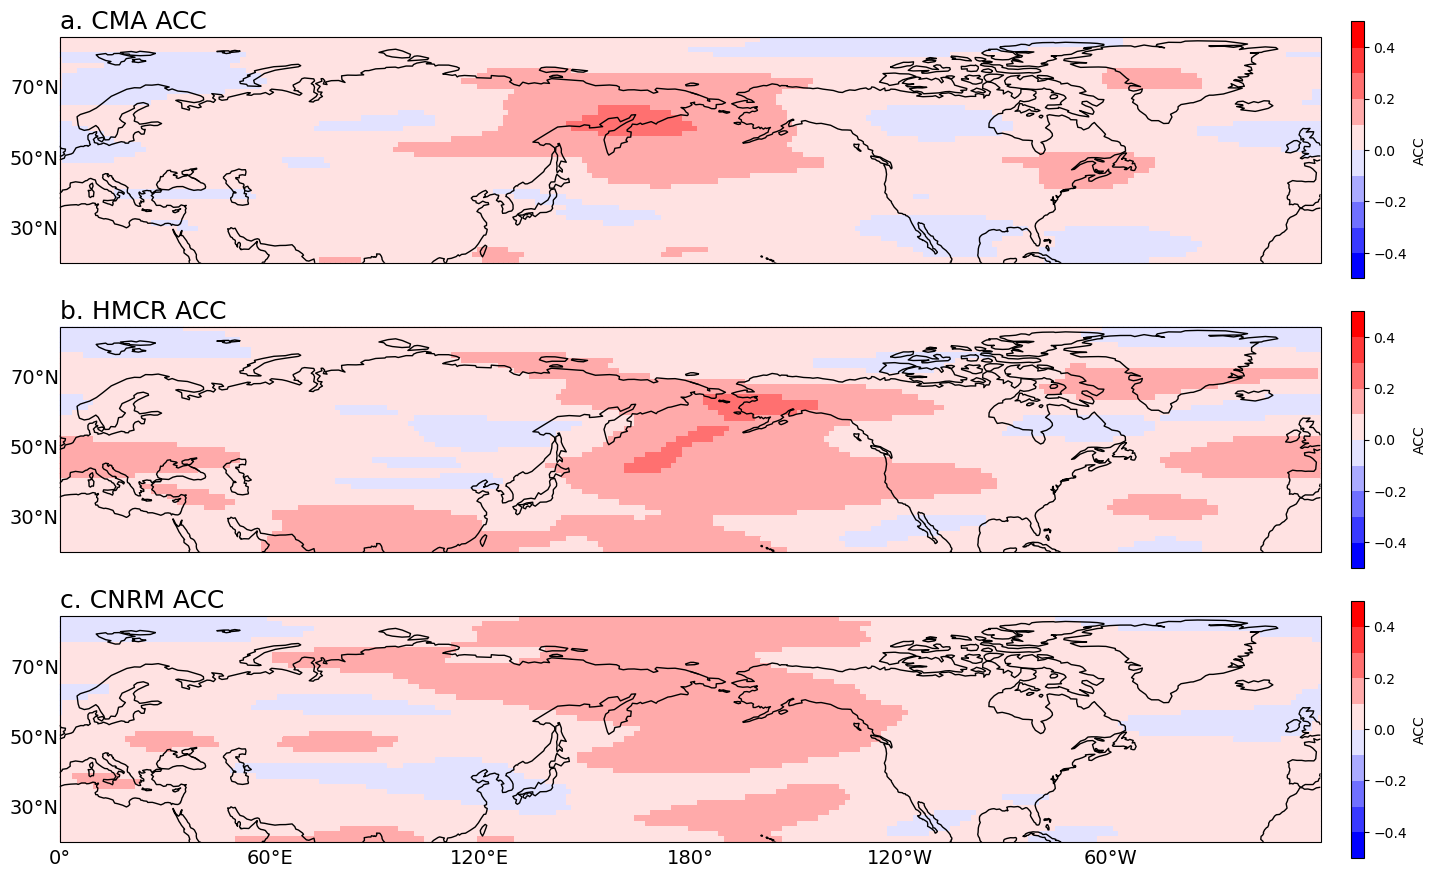

In [48]:
#plot other models acc
models11 = ['cma','hmcr','meteof']
models_n = ['CMA','HMCR','CNRM']
tt=['a.','b.','c.']
fig = plt.figure(figsize=(16,9))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
for i in range(len(models11)):
    ax = fig.add_subplot(3,1,i+1,projection=proj)
    ax.coastlines()

    fg=acc_models[models11[i]].isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "ACC"})
    ax.set_title('')
    ax.set_title(tt[i]+' '+models_n[i]+' ACC',loc='left',fontsize = 18)

    
    # ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
    #                                 facecolor='none', edgecolor='k',
    #                                 transform=ccrs.PlateCarree()))



    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.ylocator = mticker.FixedLocator([30,50,70])
    gl.xlabels_top = False
    
    gl.ylabels_right = False
    
    if i<2:
        gl.xlabels_bottom = False
    
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}


plt.tight_layout()
plt.savefig('plots/othermodels_anom-based-acc_s2s.png')
plt.show()


In [49]:
#plot other models homoegeneous acc
models11 = ['cma','hmcr','meteof']

fig = plt.figure(figsize=(16,9))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
for i in range(len(models11)):
    ax = fig.add_subplot(3,1,i+1,projection=proj)
    ax.coastlines()

    fg=acc_homs[models11[i]].isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),cbar_kwargs={'pad':0.02,'label': "ACC"})
    ax.set_title('')
    ax.set_title(tt[i]+' '+models_n[i]+' homogeneous ACC',loc='left',fontsize = 18)

    # ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
    #                                 facecolor='none', edgecolor='k',
    #                                 transform=ccrs.PlateCarree()))



    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.ylocator = mticker.FixedLocator([30,50,70])
    gl.xlabels_top = False
    
    gl.ylabels_right = False
    
    if i<2:
        gl.xlabels_bottom = False
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

plt.tight_layout()
plt.savefig('plots/othermodels_anom-based-hom-acc_s2s.png')
plt.show()

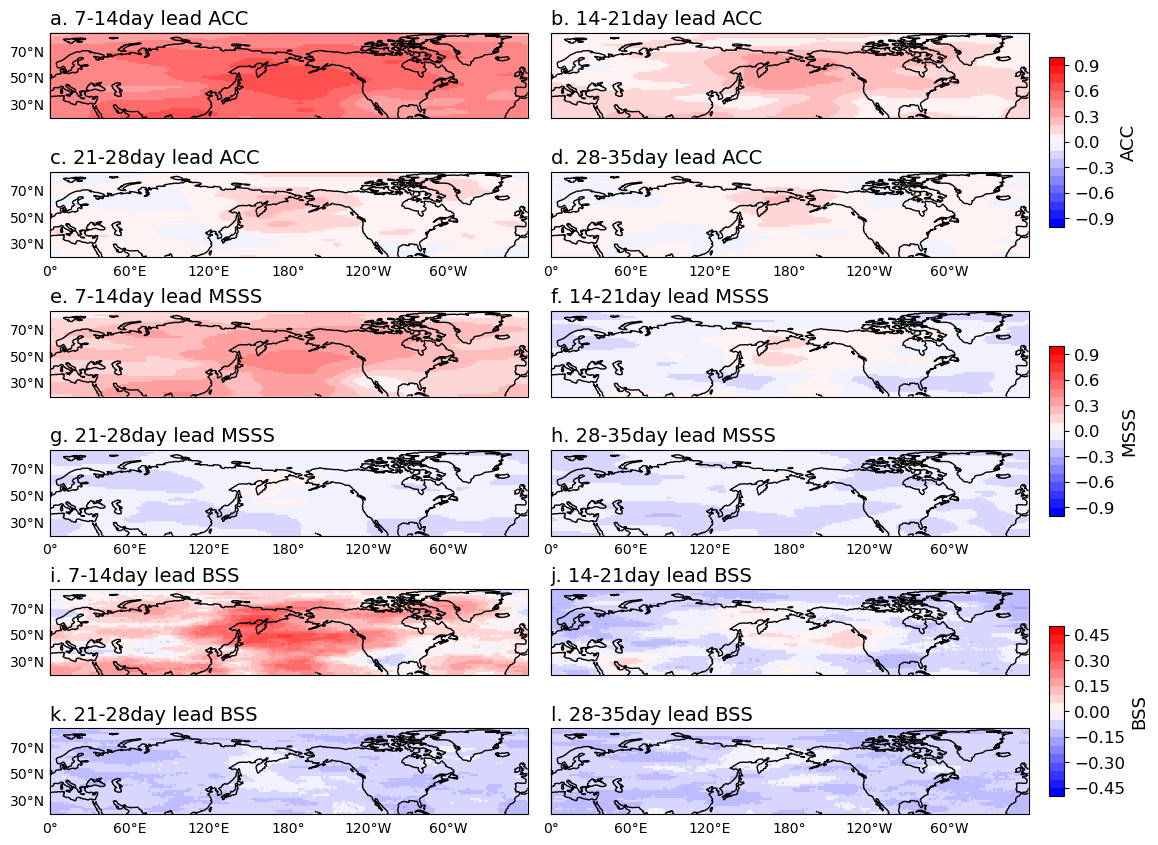

In [47]:
#Plot QSW acc, mss,bss at different lead times for ecmwf
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(15.5,8.5))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [ 'a. ', 'b. ', 'c. ', 'd. ']
   #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

ax = fig.add_subplot(6,3,1,projection=proj)
acc_ecmwf.isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('a. 7-14day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,2,projection=proj)
acc_ecmwf.isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('b. 14-21day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,4,projection=proj)
acc_ecmwf.isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('c. 21-28day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,5,projection=proj)
m=acc_ecmwf.isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('d. 28-35day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.73, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="ACC",size=13)
cbl.ax.tick_params(labelsize=12)

ax = fig.add_subplot(6,3,7,projection=proj)
mss_ecmwf.isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('e. 7-14day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,8,projection=proj)
mss_ecmwf.isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('f. 14-21day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,10,projection=proj)
mss_ecmwf.isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('g. 21-28day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,11,projection=proj)
m=mss_ecmwf.isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('h. 28-35day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.39, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="MSSS",size=13)
cbl.ax.tick_params(labelsize=12)

ax = fig.add_subplot(6,3,13,projection=proj)
BSS_ecmwf.isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('i. 7-14day lead BSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,14,projection=proj)
BSS_ecmwf.isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('j. 14-21day lead BSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,16,projection=proj)
BSS_ecmwf.isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('k. 21-28day lead BSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,17,projection=proj)
m=BSS_ecmwf.isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('l. 28-35day lead BSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.06, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="BSS",size=13)
cbl.ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.001,wspace=0.01, bottom=0.2)
plt.tight_layout()
#plt.show()
plt.savefig('plots/ECMWF_anom-based-skill_leadtime.png')

## Recalculate metrics across each year 

In [57]:
#Calculate acc on each year for ensemble mean from anomalies
accyearly={}
mssyearly={}
for i in range(len(models11)):
    fcur1 =anom_models[models11[i]].sel(time=anom_models[models11[i]].time.dt.month.isin([11,12])).mean(dim='number')
    ocur1 = anom_obs[models11[i]].sel(time=anom_obs[models11[i]].time.dt.month.isin([11,12]))

    fcur2 =anom_models[models11[i]].sel(time=anom_models[models11[i]].time.dt.month.isin([1,2])).mean(dim='number')
    ocur2 = anom_obs[models11[i]].sel(time=anom_obs[models11[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    mss_y=xr.zeros_like(fcur1.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))
    acc_y=xr.zeros_like(fcur1.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))


    accy = acc_y.expand_dims(years = years).copy()
    mssy = mss_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        ocur=xr.concat([ocur11,ocur22],dim='time')
        mssur =mss_fun(fcur,ocur)
        #msser=mssur.sel(step=slice(mssur.step[0],mssur.step[16])).mean(dim=['step'])
        accur =acc_new(fcur,ocur)
        #accer=accur.sel(step=slice(accur.step[0],accur.step[16])).mean(dim=['step'])
        mssy[j,]=mssur.values
        accy[j,]=accur.values

    accyearly[models11[i]]=accy
    mssyearly[models11[i]]=mssy

In [58]:
#Get top and bottom skill years (north pacific)
accpac_topy={}
accpac_boty={}

topy_pac={}
boty_pac={}

accpacific = {}
for i in range (len(models11)):
    
    accyearly[models11[i]].coords['longitude'] = (accyearly[models11[i]].coords['longitude'] + 180) % 360 - 180
    accyearly[models11[i]] = accyearly[models11[i]].sortby(accyearly[models11[i]].longitude)
    accy = accyearly[models11[i]].copy()
    accy.coords['longitude'] = accy.coords['longitude'] % 360
    accy = accy.sortby(accy.longitude)
    accy_pacific=accy.sel(longitude=slice(150,210),latitude=slice(70,50)) #select pacific ytears
    accspy_pac = accy_pacific.mean(dim=['latitude', 'longitude'])
    accspy_st_pac=accspy_pac.mean(dim='step')
    accspy_st_pacav=accspy_st_pac.mean(dim='years')
    accspy_st_pacsd=accspy_st_pac.std(dim='years')
    
    accspsty_topn=accspy_st_pac.where(accspy_st_pac>accspy_st_pacav+accspy_st_pacsd).dropna(dim='years')
    accpac_topy[models11[i]]=accyearly[models11[i]].sel(years=accspsty_topn.years).mean(dim='years')
    
    accspsty_botn=accspy_st_pac.where(accspy_st_pac<accspy_st_pacav-accspy_st_pacsd).dropna(dim='years')
    accpac_boty[models11[i]]=accyearly[models11[i]].sel(years=accspsty_botn.years).mean(dim='years')
    
    boty_pac[models11[i]]=accspsty_botn.years
    topy_pac[models11[i]]=accspsty_topn.years
    
    accpacific[models11[i]] = accy_pacific

In [25]:
#calc corr b/n ecmwf andand other models yearly skill
ecmwfdat1 = accpacific[models[0]].sel(years=slice('2008','2021')).mean(dim=['latitude','longitude','step'])
ecmwfdat2 = accpacific[models[0]].sel(years=slice('2002','2014')).mean(dim=['latitude','longitude','step'])
ecmwfdat3 = accpacific[models[0]].sel(years=slice('2002','2016')).mean(dim=['latitude','longitude','step'])
ecmwfdat4 = accpacific[models[0]].sel(years=slice('2002','2015')).mean(dim=['latitude','longitude','step'])
cmadat = accpacific[models[1]].mean(dim=['latitude','longitude','step'])
hmcrdat = accpacific[models[2]].sel(years=slice('2002','2014')).mean(dim=['latitude','longitude','step'])
meteofdat = accpacific[models[3]].sel(years=slice('2002','2016')).mean(dim=['latitude','longitude','step'])
execmdat = accpacific[models11[-1]].sel(years=slice('2002','2015')).mean(dim=['latitude','longitude','step'])


cmaecmwf=pearsonr(cmadat.values,ecmwfdat1.values)
hmcrecmwf=pearsonr(hmcrdat.values,ecmwfdat2.values)
meteofecmwf=pearsonr(meteofdat.values,ecmwfdat3.values)
execmecmwf=pearsonr(execmdat.values,ecmwfdat4.values)
print(cmaecmwf)
print(hmcrecmwf)
print(meteofecmwf)
print(execmecmwf)

PearsonRResult(statistic=0.6872062624139339, pvalue=0.006617904499731925)
PearsonRResult(statistic=0.09804277847632713, pvalue=0.7499934352834007)
PearsonRResult(statistic=0.5346833093486336, pvalue=0.04002163860625689)
PearsonRResult(statistic=0.5168175168120372, pvalue=0.058445749266029426)


In [65]:
#calc corr b/n ecmwf and ecmwfv2 across years
ecmwfdat4 = accpacific[models[0]].sel(years=slice('2002','2015')).mean(dim=['latitude','longitude','step'])
execmdat = accpacific[models11[-1]].sel(years=slice('2002','2015')).mean(dim=['latitude','longitude','step'])
execmecmwf=pearsonr(execmdat.values,ecmwfdat4.values)

print(execmecmwf)

PearsonRResult(statistic=0.6744453268636315, pvalue=0.00815412244258598)


In [115]:
#Calculate acc and mss on each initialization date for ensemble mean
accinit={}
mssinit={}

for i in range (len(models11)):
    fcur1 =anom_models[models11[i]].mean(dim='number')
    ocur1 = anom_obs[models11[i]]

    a = pd.to_datetime('2020-11-17')
    dates = []
    days=[]
    months=[]
    for j in range (23):
        da = a.day
        mo = a.month
        months.append(mo)
        days.append(da)

        dates.append(str(mo)+'-'+str(da))
        if j%2==0:
            a=a+timedelta(4)
        else:
            a=a+timedelta(3)

    mss_i=xr.zeros_like(fcur1.sel(time = (fcur1.time.dt.month==months[0])&(fcur1.time.dt.day==days[0])).mean(dim='time'))
    acc_i=xr.zeros_like(fcur1.sel(time = (fcur1.time.dt.month==months[0])&(fcur1.time.dt.day==days[0])).mean(dim='time'))


    acci = acc_i.expand_dims(dim={"initialization":dates}, axis=0).copy()
    mssi = mss_y.expand_dims(dim={"initialization":dates}, axis=0).copy()
    
    a = pd.to_datetime('2020-11-17')
    
    for j in range (23):
        da = a.day
        mo = a.month
        months.append(mo)
        days.append(da)
        
        fcur11=fcur1.sel(time = (fcur1.time.dt.month==mo)&(fcur1.time.dt.day==da))
        ocur11 = ocur1.sel(time = (fcur1.time.dt.month==mo)&(fcur1.time.dt.day==da))
        
        accur =acc_new(fcur11,ocur11)
        acci[j,]=accur.values
        dates.append(str(mo)+'-'+str(da))
        if j%2==0:
            a=a+timedelta(4)
        else:
            a=a+timedelta(3)
          
    accinit[models11[i]]=acci.copy()
    print(accinit[models11[i]])
#     accinit[models11[i]]=mssi

<xarray.DataArray 'q' (initialization: 23, step: 33, latitude: 43,
                       longitude: 240)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         n

In [116]:
#Calculate acc and mss on each year for ensemble mean but only for north pacific


acci_pacific = {}
for i in range (len(models11)):
    
#     accinit[models11[i]].coords['longitude'] = (accinit[models11[i]].coords['longitude'] + 180) % 360 - 180
#     accinit[models11[i]] = accinit[models11[i]].sortby(accinit[models11[i]].longitude)
    acci = accinit[models11[i]].copy()
    acci.coords['longitude'] = acci.coords['longitude'] % 360
    acci = acci.sortby(acci.longitude)
    acci_pac=acci.sel(longitude=slice(150,210),latitude=slice(70,50))
    accspy_pac = acci_pac.mean(dim=['latitude', 'longitude'])

    
    acci_pacific[models11[i]] = acci_pac

In [121]:
#correlate ecmwf and ecmwfv2 skill across inits
yax1 = acci_pacific[models11[0]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])
yax2 = acci_pacific[models11[-1]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])
execmecmwf_init=pearsonr(yax1.values,yax2.values)

print(execmecmwf_init)

PearsonRResult(statistic=0.1674125128556733, pvalue=0.44515272927687777)


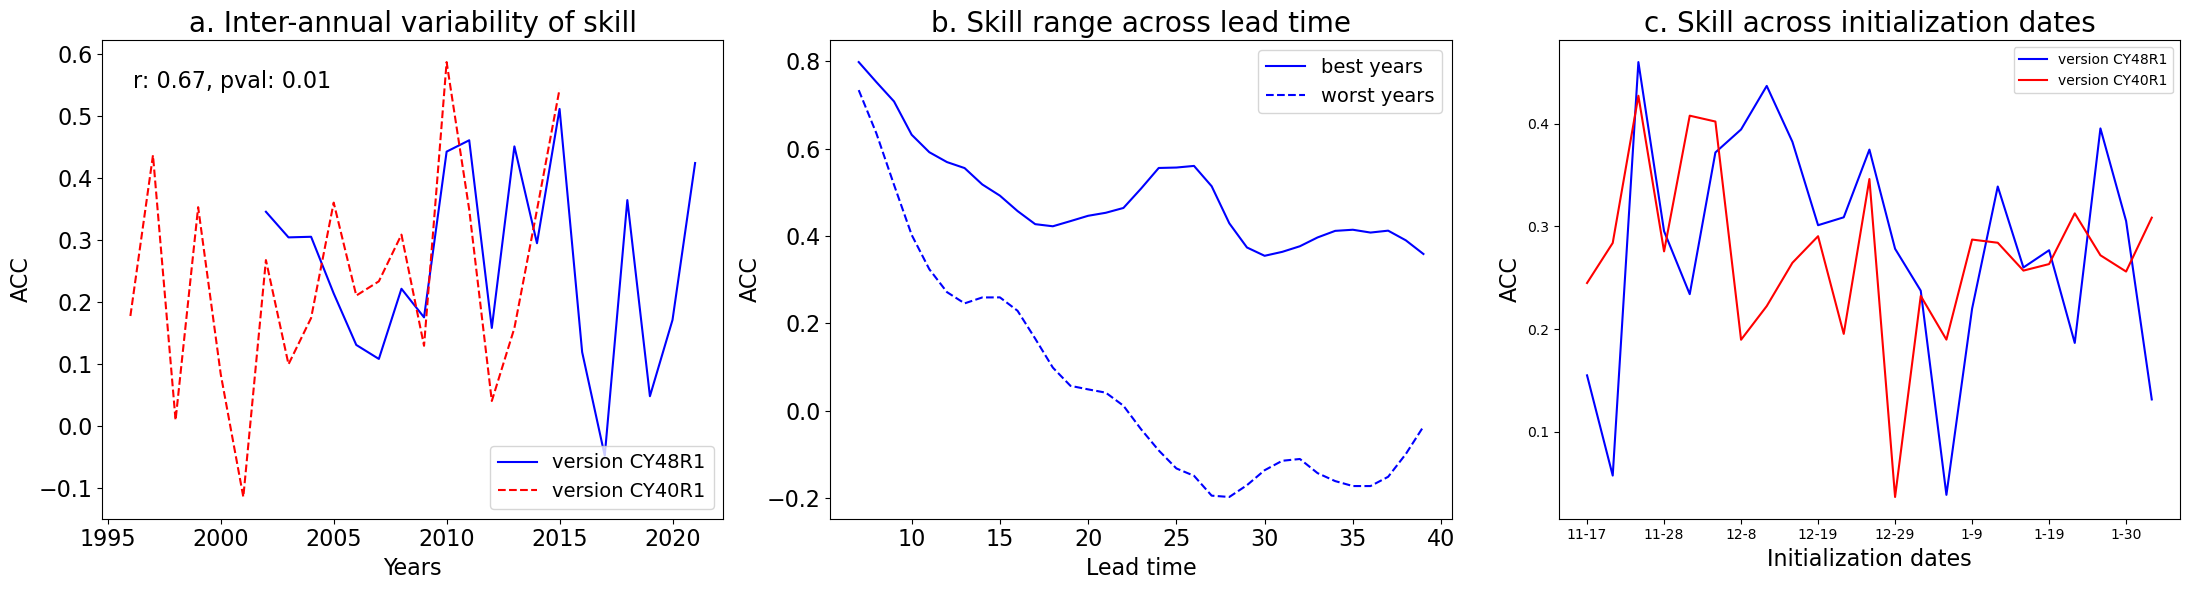

In [124]:
#plot Variability and best vs. worst ECMWF (pacific based)

fig=plt.figure(figsize = (22,6))


lets=['a. ','b. ','c. ', 'd. ']

ax1 = fig.add_subplot(1,3,1)

ax1.set_xlabel('Years',fontsize = 16)
ax1.set_ylabel('ACC',fontsize = 16)


rs=[0.61,0.38,0.5]
ps=[0.02,0.12,0.02]


accy_mn = accpacific[models[0]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])

xax=accy_mn.years
yax=accy_mn #- accy_mn.mean()
ax1.plot(xax,yax, label ='version CY48R1',color='b')

accy_mn2 = accpacific[models[-1]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])

xax=accy_mn2.years
yax=accy_mn2 #- accy_mn.mean()
ax1.plot(xax,yax, label ='version CY40R1',color='r', linestyle='dashed')
plt.legend(fontsize=14, loc='lower right')

ax1.set_title(lets[0]+'Inter-annual variability of skill',fontsize = 20)
r="{:.2f}".format(execmecmwf[0])
p="{:.2f}".format(execmecmwf[1])
ax1.text(0.05,0.9,'r: '+str(r)+', pval: '+str(p),transform=ax1.transAxes,fontsize=16)


# plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax1 = fig.add_subplot(1,3,2)

xax=np.arange(7,40)
accpac_topyy = accpac_topy[models[0]].copy()
accpac_topyy.coords['longitude'] = accpac_topyy.coords['longitude'] % 360
accpac_topyy = accpac_topyy.sortby(accpac_topyy.longitude)
accytop_pacific=accpac_topyy.sel(longitude=slice(150,210),latitude=slice(70,50))
acc_top = accytop_pacific.mean(dim=['latitude','longitude'])
ax1.plot(xax,acc_top,label='best years',color='b')

#ax = fig.add_subplot(3,2,2*i+2)
accpac_botyy = accpac_boty[models[0]].copy()
accpac_botyy.coords['longitude'] = accpac_botyy.coords['longitude'] % 360
accpac_botyy = accpac_botyy.sortby(accpac_botyy.longitude)
accybot_pacific=accpac_botyy.sel(longitude=slice(150,210),latitude=slice(70,50))
acc_bot = accybot_pacific.mean(dim=['latitude','longitude'])

ax1.plot(xax,acc_bot,label='worst years',color='b', linestyle='dashed')
ax1.set_xlabel('Lead time',fontsize = 16)
ax1.set_ylabel('ACC',fontsize = 16)
# ax1.vlines(20,-0.02,0.26, color ='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)

ax1.set_title("b. Skill range across lead time",fontsize = 20)

ax1 = fig.add_subplot(1,3,3)
ax1.set_xlabel('Initialization dates',fontsize = 16)
ax1.set_ylabel('ACC',fontsize = 16)

# for i in range (len(models)):
#     accy_mn = accpacific[models[i]].mean(dim=['latitude','longitude','step'])
    
#     xax=accy_mn.years
#     yax=accy_mn #- accy_mn.mean()
#     if i==0:
#         ax1.plot(xax,yax, label = models1[i])
#     else:
#         ax1.plot(xax,yax, label = models1[i]+': r='+str(rs[i-1])+',p='+str(ps[i-1]))
        
# ax1.set_title(lets[0]+'Inter-annual variability of skill',fontsize = 20)

accy_mn = acci_pacific[models11[0]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])
#accy_mn2=accy_mn.isel(initialization=slice(1,-1))
xax=accy_mn.initialization
yax=accy_mn#2 #- accy_mn.mean()
sl=mk.original_test(yax)[-2]
pv=mk.original_test(yax)[2]
labels='version CY48R1'#, slope: '+'%s' % float('%.1g' % sl)+' at p:'+'%s' % float('%.1g' % pv)
ax1.plot(xax,yax, label =labels,color='b')

accy_mn = acci_pacific[models11[-1]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])
#accy_mn2=accy_mn.isel(initialization=slice(1,-1))
xax=accy_mn.initialization
yax=accy_mn#2 #- accy_mn.mean()
sl=mk.original_test(yax)[-2]
pv=mk.original_test(yax)[2]
labels='version CY40R1'#, slope: '+'%s' % float('%.1g' % sl)+' at p:'+'%s' % float('%.1g' % pv)
ax1.plot(xax,yax, label =labels,color='r')

ticks = ax1.get_xticks()
# Select every other tick and label
new_ticks = ticks[::3]

# Set the new ticks and labels
ax1.set_xticks(new_ticks)
plt.legend()
ax1.set_title("c. Skill across initialization dates",fontsize = 20)

plt.tight_layout()
plt.savefig('plots/ECMWF_acc_variability_with_init.png')